# Algorithm 6

In [1]:
from trajectory_generator import *
from functions import *
import numpy as np
import matplotlib.pyplot as plt
from cmap import Colormap
from scipy.special import comb
from scipy import integrate
from scipy import special
from itertools import combinations_with_replacement
from collections import Counter
import findiff

## Van der Pol oscillator

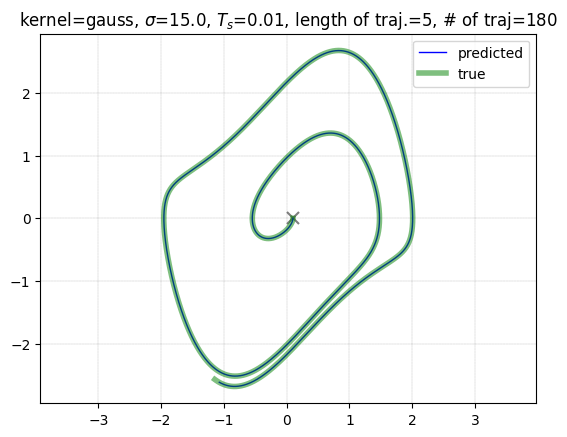

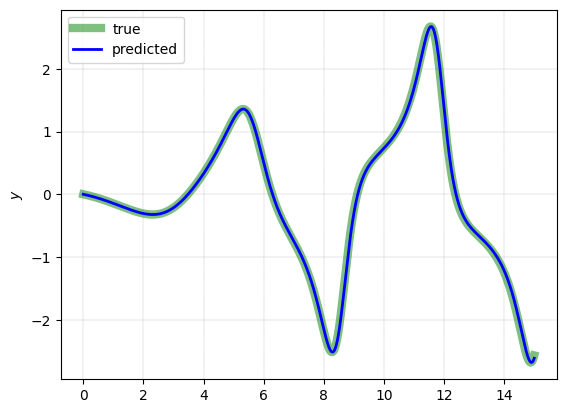

In [2]:
d=2
mu=1
model = VanderPol(mu)

m = 5
n = 7
rm = comb(m+d,d, exact = True) # dimension of V_{p,m}
rn = comb(n+d,d, exact = True) # dimension of V_{p,n}
M = 5*rn # number of initial values
Ts = 0.01 # sampling period
kernel_name = 'gauss' #'exp' or 'gauss'
assert kernel_name == 'exp' or  kernel_name =='gauss', 'kernel_name should be exp or gauss'

l_traj = 5 #number of snapshots
X_traj=np.zeros((d,l_traj,M))
width = 1
X_traj[:,0,:]=2*width*np.random.rand(d,M)-width #uniformly distribtuion from [-width, width]^2
for i in range(l_traj-1):
  X_traj[:,i+1,:]=model.evaluate(X_traj[:,i,:], Ts, h=1e-5)
X=np.hstack([X_traj[:,i,:] for i in range(l_traj)]) #data

veloc_exact = model.vector_field(X) # exact velocities 

# esimated velocities with the finite difference method
fd_coef=[np.array(findiff.coefficients(deriv=1, offsets=[i-j for i in range(l_traj)])['coefficients']) \
         for j in range(l_traj)] #coefficients for the finite difference method
veloc_esti = np.hstack([np.sum(X_traj*fd_coef[i].reshape(-1,1), axis=1)/Ts for i in range(l_traj)]) 

Y=veloc_esti # velocities we will use

# select (x_0, y_0); we take the one closest to the mean of the data
idx0 = np.argmin(np.sum(np.abs(X-X.mean(axis=1, keepdims=True))), axis=0)
x0=X[:,[idx0]]
y0=Y[:,[idx0]]
Y_tilde = Y - y0

# Computation of V_n^X and W_m^{X,Y}
if kernel_name=='exp':
  constV = constV_exp #V_n^X with exponential kernel
  constW = constW_exp #W_m^{X,Y} with exponential kernel
  sigma_kernel = 1.0 #sigma
elif kernel_name == 'gauss':
  constV = constV_gauss #V_n^X  with Gaussian kernel 
  constW = constW_gauss #W_m^{X,Y} with Gaussian kernel 
  sigma_kernel = 15.0 #sigma
  Gm_nonflat = np.ones((m+1,d))
  for i in range(m):
    Gm_nonflat[i+1] = Gm_nonflat[i]*(i+1)
  Gm = make_combinatorial_products(Gm_nonflat).reshape(-1,1)

V = constV(X, x0, n, sigma_kernel) # V_n^X
W = constW(X, Y_tilde, x0, m, sigma_kernel) # W_m^{X,Y}

#Computation of A-hat
A = (W@(np.linalg.pinv(V)))[:,:rm]

def F_estimated_exp(x):
  return sigma_kernel*(A[1:d+1,:])@(constV_exp(x ,x0, m, sigma_kernel)) + y0

def F_estimated_gauss(x):
  return np.sum((sigma_kernel**2)*constDV_gauss(x ,x0, m, sigma_kernel)*((A/Gm)@(constV_gauss(x ,x0, m, sigma_kernel))), axis=1) + y0


if kernel_name == 'exp':
  F = F_estimated_exp
elif kernel_name =='gauss':
  F = F_estimated_gauss

mymodel = model_user_defined(F)


# Figure for trajectries
h = 1e-3 # step size
x_init = np.array([[0.1,0]]).T # initial points

T = 15 # time period
t_axis=np.linspace(0,T,int(T/h))
Z_predicted=mymodel.generate_trajectory(x_init, T, h=h) #predicted trajectories
Z_exact=model.generate_trajectory(x_init, T, h=h) #true trajectories

# graph of trajectories
ax=plt.figure().add_subplot()
ax.grid(True, linestyle='--', color='k', linewidth=0.1)
ax.plot(x_init[0,:], x_init[1,:], 'x', c='k', markersize=8, markeredgewidth=1.5, alpha=0.5)
ax.plot(Z_predicted[:,0],  Z_predicted[:,1],  'blue', linestyle='-' , linewidth=1, label = 'predicted', alpha=1)
ax.plot(Z_exact[:,0],  Z_exact[:,1],  'green', linestyle='-' , linewidth=4, label='true', alpha=0.5)
ax.axis("equal")
ax.set_title(f'kernel={kernel_name}, $\sigma$={sigma_kernel}, $T_s$={Ts}, length of traj.={l_traj}, # of traj.={M}')
ax.legend()

# graph of y-axis of trajectories
ax=plt.figure().add_subplot()
ax.grid(True, linestyle='--', color='k', linewidth=0.1)
ax.plot(t_axis,Z_exact[:,1], label='true', linewidth=6, alpha=0.5, color='green')
ax.plot(t_axis,Z_predicted[:,1], label='predicted',linewidth=2, color='blue')
ax.set_ylabel('$y$')
ax.legend()
plt.show()
plt.show()

## Lorenz attractor

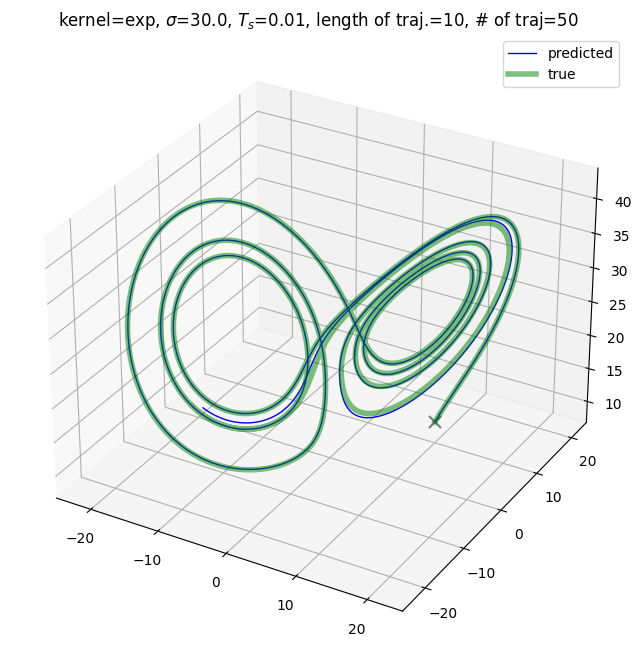

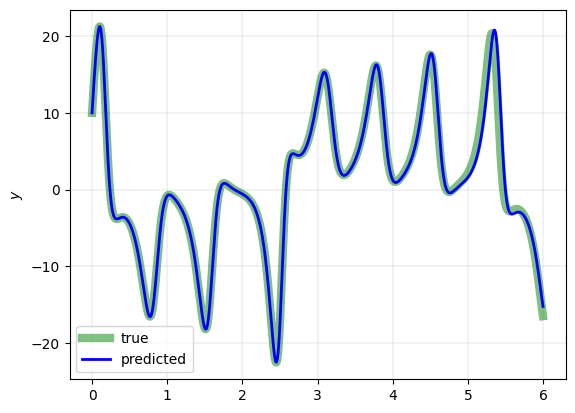

In [3]:
d=3
model = Lorenz()

m = 2
n = 4
rm = comb(m+d,d, exact = True) # dimension of V_{p,m}
rn = comb(n+d,d, exact = True) # dimension of V_{p,n}
M = 50 # number of initial values
Ts = 0.01 # sampling period
kernel_name = 'exp' #'exp' or 'gauss'
assert kernel_name == 'exp' or  kernel_name =='gauss', 'kernel_name should be exp or gauss'

l_traj = 10 #number of snapshots
X_traj=np.zeros((d,l_traj,M))
width = 10
X_traj[:,0,:]=2*width*np.random.rand(d,M)-width #uniformly distribtuion from [-width, width]^2
for i in range(l_traj-1):
  X_traj[:,i+1,:]=model.evaluate(X_traj[:,i,:], Ts, h=1e-5)
X=np.hstack([X_traj[:,i,:] for i in range(l_traj)]) #data

veloc_exact = model.vector_field(X) # exact velocities 

# esimated velocities with the finite difference method
fd_coef=[np.array(findiff.coefficients(deriv=1, offsets=[i-j for i in range(l_traj)])['coefficients']) for j in range(l_traj)] #coefficients for the finite difference method
veloc_esti = np.hstack([np.sum(X_traj*fd_coef[i].reshape(-1,1), axis=1)/Ts for i in range(l_traj)]) 

Y=veloc_esti # velocities we will use

# select (x_0, y_0); we take the one closest to the mean of the data
idx0 = np.argmin(np.sum(np.abs(X-X.mean(axis=1, keepdims=True))), axis=0)
x0=X[:,[idx0]]
y0=Y[:,[idx0]]
Y_tilde = Y - y0

# Computation of V_n^X and W_m^{X,Y}
if kernel_name=='exp':
  constV = constV_exp #V_n^X with exponential kernel
  constW = constW_exp #W_m^{X,Y} with exponential kernel
  sigma_kernel = 30.0 #sigma
elif kernel_name == 'gauss':
  constV = constV_gauss #V_n^X  with Gaussian kernel 
  constW = constW_gauss #W_m^{X,Y} with Gaussian kernel 
  sigma_kernel = 600.0 #sigma
  Gm_nonflat = np.ones((m+1,d))
  for i in range(m):
    Gm_nonflat[i+1] = Gm_nonflat[i]*(i+1)
  Gm = make_combinatorial_products(Gm_nonflat).reshape(-1,1)

V = constV(X, x0, n, sigma_kernel) # V_n^X
W = constW(X, Y_tilde, x0, m, sigma_kernel) # W_m^{X,Y}

#Computation of A-hat
A = (W@(np.linalg.pinv(V)))[:,:rm]

def F_estimated_exp(x):
  return sigma_kernel*(A[1:d+1,:])@(constV_exp(x ,x0, m, sigma_kernel)) + y0

def F_estimated_gauss(x):
  return np.sum((sigma_kernel**2)*constDV_gauss(x ,x0, m, sigma_kernel)*((A/Gm)@(constV_gauss(x ,x0, m, sigma_kernel))), axis=1) + y0


if kernel_name == 'exp':
  F = F_estimated_exp
elif kernel_name =='gauss':
  F = F_estimated_gauss

mymodel = model_user_defined(F)

# Figure for trajectries
h = 1e-3 #step size
x_init = np.array([[10,10,10]]).T #initial points

T = 6 # time period
t_axis=np.linspace(0,T,int(T/h))
Z_predicted=mymodel.generate_trajectory(x_init, T, h=h) #predicted trajectories
Z_exact=model.generate_trajectory(x_init, T, h=h) #true trajectories

# graph of trajectories
ax=plt.figure(figsize=(8,8)).add_subplot(projection='3d')
ax.grid(True, linestyle='--', color='k', linewidth=0.1)
ax.plot(x_init[0,:], x_init[1,:], x_init[2,:], 'x', c='k', markersize=8, markeredgewidth=1.5, alpha=0.5)
ax.plot(Z_predicted[:,0],  Z_predicted[:,1], Z_predicted[:,2], 'blue', linestyle='-' , linewidth=1, label = 'predicted', alpha=1)
ax.plot(Z_exact[:,0],  Z_exact[:,1], Z_exact[:,2], 'green', linestyle='-' , linewidth=4, label='true', alpha=0.5)
ax.axis("equal")
ax.set_title(f'kernel={kernel_name}, $\sigma$={sigma_kernel}, $T_s$={Ts}, length of traj.={l_traj}, # of traj.={M}')
ax.legend()

# graph of y-axis of trajectories
ax=plt.figure().add_subplot()
ax.grid(True, linestyle='--', color='k', linewidth=0.1)
ax.plot(t_axis,Z_exact[:,1], label='true', linewidth=6, alpha=0.5, color='green')
ax.plot(t_axis,Z_predicted[:,1], label='predicted',linewidth=2, color='blue')
ax.set_ylabel('$y$')
ax.legend()
plt.show()